In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

Set working directory

In [3]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/PU1/'
workingDirectory = '/home/h1bennet/brain_aging/results/00_PU1_H3K27Ac_4month_vs_25month/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

make folder for figures

In [6]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

In [7]:
tagdirs = ['05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
           '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
           '05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
           '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA',
           '07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC',
           '07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA']

In [8]:
inputdirs = ['02_mouse_MPSIIIAhet_M_4month_PU1_ChIP_input_AL_l20200925_ATCCACTG_AGGTGCGT',
             '02_mouse_MPSIIIAhet_M_4month_PU1_ChIP_input_AL_l20200925_ATCCACTG_AGGTGCGT',
             '02_mouse_MPSIIIAhet_M_4month_PU1_ChIP_input_AL_l20200925_ATCCACTG_AGGTGCGT',
             'mouse_C57_M_PU1_ChIP_input_MPSIIIAWTP240PU1_408_AL_l20191122_CTAGCT',
             'mouse_C57_M_PU1_ChIP_input_MPSIIIAWTP240PU1_408_AL_l20191122_CTAGCT',
             'mouse_C57_M_PU1_ChIP_input_MPSIIIAWTP240PU1_408_AL_l20191122_CTAGCT']

# Call Peaks with matched inputs

In [9]:
%%bash
# delete the existing script file
rm ./peakCalling_homer.sh
# create a script file
touch ./peakCalling_homer.sh

# if directories don't exist, create them
if [ ! -d ./peak_files/ ]; then mkdir ./peak_files; fi

rm: cannot remove ‘./peakCalling_homer.sh’: No such file or directory


In [10]:

with open('./peakCalling_homer.sh', 'w') as f:
    for tagdir, inputdir in zip(tagdirs, inputdirs):
        print('analyzing:', tagdir)
        print('input:', inputdir)
        print()
        find_peaks_fw = ['findPeaks', dataDirectory + '/' + tagdir,
                          '-i', inputDirectory + '/' + inputdir,
                          '-size 1000 -minDist 2500',
                          '-o',
                          workingDirectory + '/peak_files/' + tagdir + '_fixedwidth_peaks.tsv',
                          '&', '\n\n']
        
        find_peaks_vw = ['findPeaks', dataDirectory + '/' + tagdir,
                          '-i', inputDirectory + '/' + inputdir,
                          '-region',
                          '-size 1000 -minDist 2500',
                          '-o',
                          workingDirectory + '/peak_files/' + tagdir + '_variablewidth_peaks.tsv',
                          '&', '\n\n']
        
        find_peaks_nfr = ['findPeaks', dataDirectory + '/' + tagdir,
                          '-i', inputDirectory + '/' + inputdir,
                          '-nfr', '-size 200',
                          '-o',
                          workingDirectory + '/peak_files/' + tagdir + '_nfr_peaks.tsv',
                          '&', '\n\n']

        # write commands to file
        f.write(' '.join(find_peaks_fw))
        f.write(' '.join(find_peaks_vw))
        f.write(' '.join(find_peaks_nfr))      
        
    f.close()

analyzing: 05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG
input: 02_mouse_MPSIIIAhet_M_4month_PU1_ChIP_input_AL_l20200925_ATCCACTG_AGGTGCGT

analyzing: 05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG
input: 02_mouse_MPSIIIAhet_M_4month_PU1_ChIP_input_AL_l20200925_ATCCACTG_AGGTGCGT

analyzing: 05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC
input: 02_mouse_MPSIIIAhet_M_4month_PU1_ChIP_input_AL_l20200925_ATCCACTG_AGGTGCGT

analyzing: 07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA
input: mouse_C57_M_PU1_ChIP_input_MPSIIIAWTP240PU1_408_AL_l20191122_CTAGCT

analyzing: 07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC
input: mouse_C57_M_PU1_ChIP_input_MPSIIIAWTP240PU1_408_AL_l20191122_CTAGCT

analyzing: 07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA
input: mouse_C57_M_PU1_ChIP_input_MPSIIIAWTP240PU1_408_AL_l20191122_CTAGCT



# Merge peaks

In [11]:
%%bash
if [ ! -d ./merged_peaks/ ]; then mkdir ./merged_peaks; fi
mergePeaks ./peak_files/*variablewidth* > merged_peaks/vw_peaks_merged.txt
mergePeaks ./peak_files/*fixedwidth* > merged_peaks/fw_peaks_merged.txt
mergePeaks ./peak_files/*nfr_peaks.tsv* > merged_peaks/nfr_peaks_merged.txt

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG_variablewidth_peaks.tsv (20463 total) and ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG_variablewidth_peaks.tsv (20463 total)
	Comparing ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG_variablewidth_peaks.tsv (20463 total) and ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG_variablewidth_peaks.tsv (20245 total)
	Comparing ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG_variablewidth_peaks.tsv (20463 total) and ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC_variablewidth_peaks.tsv (15429 total)
	Comparing ./peak_files/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG_v

Convert merged peaks to bed files

In [12]:
%%bash
if [ ! -d ./bed_files/ ]; then mkdir ./bed_files; fi

# delete the existing script file
rm ./make_bed.sh
# create a script file
touch ./make_bed.sh

for peakfile in ./merged_peaks/*;
do bedfile=${peakfile/merged_peaks/bed_files};
bedfile=${bedfile/.txt/.bed}
echo "pos2bed.pl $peakfile > $bedfile" >> make_bed.sh
done


rm: cannot remove ‘./make_bed.sh’: No such file or directory


Best to add labels to the bed files so that we can use them on the browser

In [46]:
%%bash

echo 'track name="PU1_H3K27Ac_FW" description="PU1 Nuclei H3K27Ac Chip-seq Fixed Width Peaks"' \
| cat - ./bed_files/fw_peaks_merged.bed \
> temp && mv temp ./bed_files/fw_peaks_merged.bed

echo 'track name="PU1_H3K27Ac_NFR" description="PU1 Nuclei H3K27Ac Chip-seq Nucleosome Free Regions"' \
| cat - ./bed_files/nfr_peaks_merged.bed \
> temp && mv temp ./bed_files/nfr_peaks_merged.bed

echo 'track name="PU1_H3K27Ac_VW" description="PU1 Nuclei H3K27Ac Chip-seq Variable Width Peaks"' \
| cat - ./bed_files/vw_peaks_merged.bed \
> temp && mv temp ./bed_files/vw_peaks_merged.bed

# Annotate peaks

In [13]:
%%bash
# delete the existing script file
rm ./annotatePeaks_homer.sh
# create a script file
touch ./annotatePeaks_homer.sh

if [ ! -d ./annotated_peaks/ ]; then mkdir ./annotated_peaks; fi

rm: cannot remove ‘./annotatePeaks_homer.sh’: No such file or directory


In [14]:
tagdirs_full = [dataDirectory+i for i in tagdirs]

In [15]:
with open('./annotatePeaks_homer.sh', 'w') as f:
    annotate_fw_raw = ['annotatePeaks.pl', './merged_peaks/fw_peaks_merged.txt',
                       'mm10', '-size 1000', '-raw', '-d \\\n',
                       ' \\\n'.join(tagdirs_full), '>',
                       './annotated_peaks/ann_raw_idr_fw_peaks_merged.txt &\n\n']
    
    annotate_fw_norm = ['annotatePeaks.pl', './merged_peaks/fw_peaks_merged.txt',
                       'mm10', '-size 1000', '-norm 1e7', '-d \\\n',
                       ' \\\n'.join(tagdirs_full), '>',
                       './annotated_peaks/ann_norm_idr_fw_peaks_merged.txt &\n\n']
    
    annotate_nfr_raw = ['annotatePeaks.pl', './merged_peaks/nfr_peaks_merged.txt',
                       'mm10', '-size 1000', '-raw', '-d \\\n',
                       ' \\\n'.join(tagdirs_full), '>',
                       './annotated_peaks/ann_raw_idr_nfr_peaks_merged.txt &\n\n']
    
    annotate_nfr_norm = ['annotatePeaks.pl', './merged_peaks/nfr_peaks_merged.txt',
                       'mm10', '-size 1000', '-norm 1e7', '-d \\\n',
                       ' \\\n'.join(tagdirs_full), '>',
                       './annotated_peaks/ann_norm_idr_nfr_peaks_merged.txt &\n\n']
    
    annotate_vw_raw = ['annotatePeaks.pl', './merged_peaks/vw_peaks_merged.txt',
                   'mm10', '-size given', '-raw', '-d \\\n',
                   ' \\\n'.join(tagdirs_full), '>',
                   './annotated_peaks/ann_raw_idr_vw_peaks_merged.txt &\n\n']

    annotate_vw_norm = ['annotatePeaks.pl', './merged_peaks/vw_peaks_merged.txt',
                       'mm10', '-size given', '-norm 1e7', '-d \\\n',
                       ' \\\n'.join(tagdirs_full), '>',
                       './annotated_peaks/ann_norm_idr_vw_peaks_merged.txt &']
    
    f.write(' '.join(annotate_fw_raw))    
    f.write(' '.join(annotate_fw_norm))
    f.write(' '.join(annotate_nfr_raw))    
    f.write(' '.join(annotate_nfr_norm))
    f.write(' '.join(annotate_vw_raw))    
    f.write(' '.join(annotate_vw_norm))
    
    f.close()

# Summary plots

In [16]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

Read in annotation files

In [17]:
# import annotation file
df, mat = read_annotated_peaks('./annotated_peaks/ann_norm_idr_vw_peaks_merged.txt')

# # try with dropped sample
# dropsamp = ['00_mouse_BL6_M_8week_PU1_ChIP_H3K27Ac_3_AL_20191226_GTAGAG_ds']

# df = df.drop(dropsamp, axis=1)
# mat = mat.drop(dropsamp, axis=1)

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low tag peaks

In [18]:
mat.columns

Index(['/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC',
       '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/PU_1/WT/07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA'],
      dtype='object')

In [19]:
thresh = 16

print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
peaks = []
mat = mat.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(mat.index[(mat > thresh).sum(1) > 1])
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

27227 total peaks
filtering low tag count peaks
23266 total peaks


### Make folder for figures

In [20]:
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### Mean variance plot

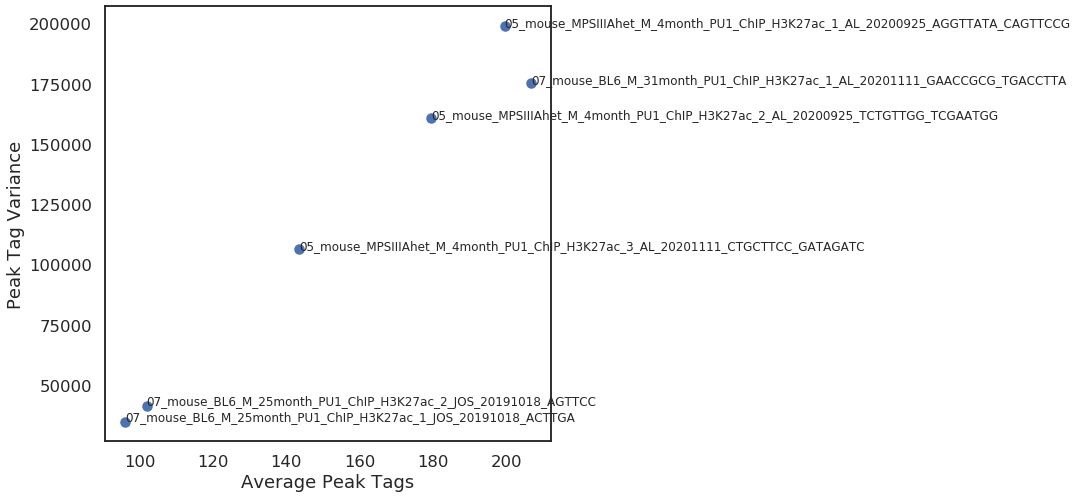

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png', bbox_inches='tight')

### Try with quantile normalized data

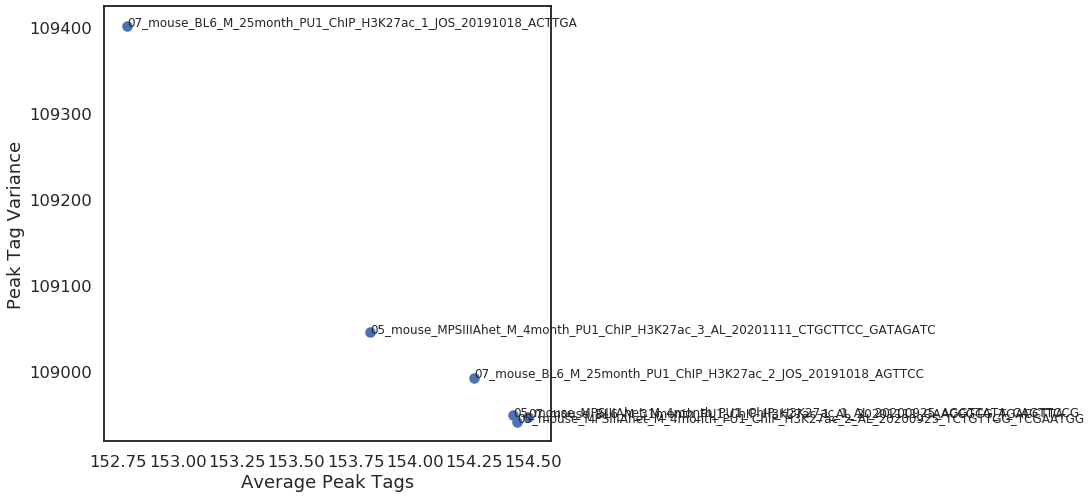

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('/').str[-1],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png', bbox_inches='tight')

### Correlation heatmap

In [23]:
mat.columns = mat.columns.str.split('/').str[-1]
mat_quant.columns = mat_quant.columns.str.split('/').str[-1]
mat_distal.columns = mat_distal.columns.str.split('/').str[-1]

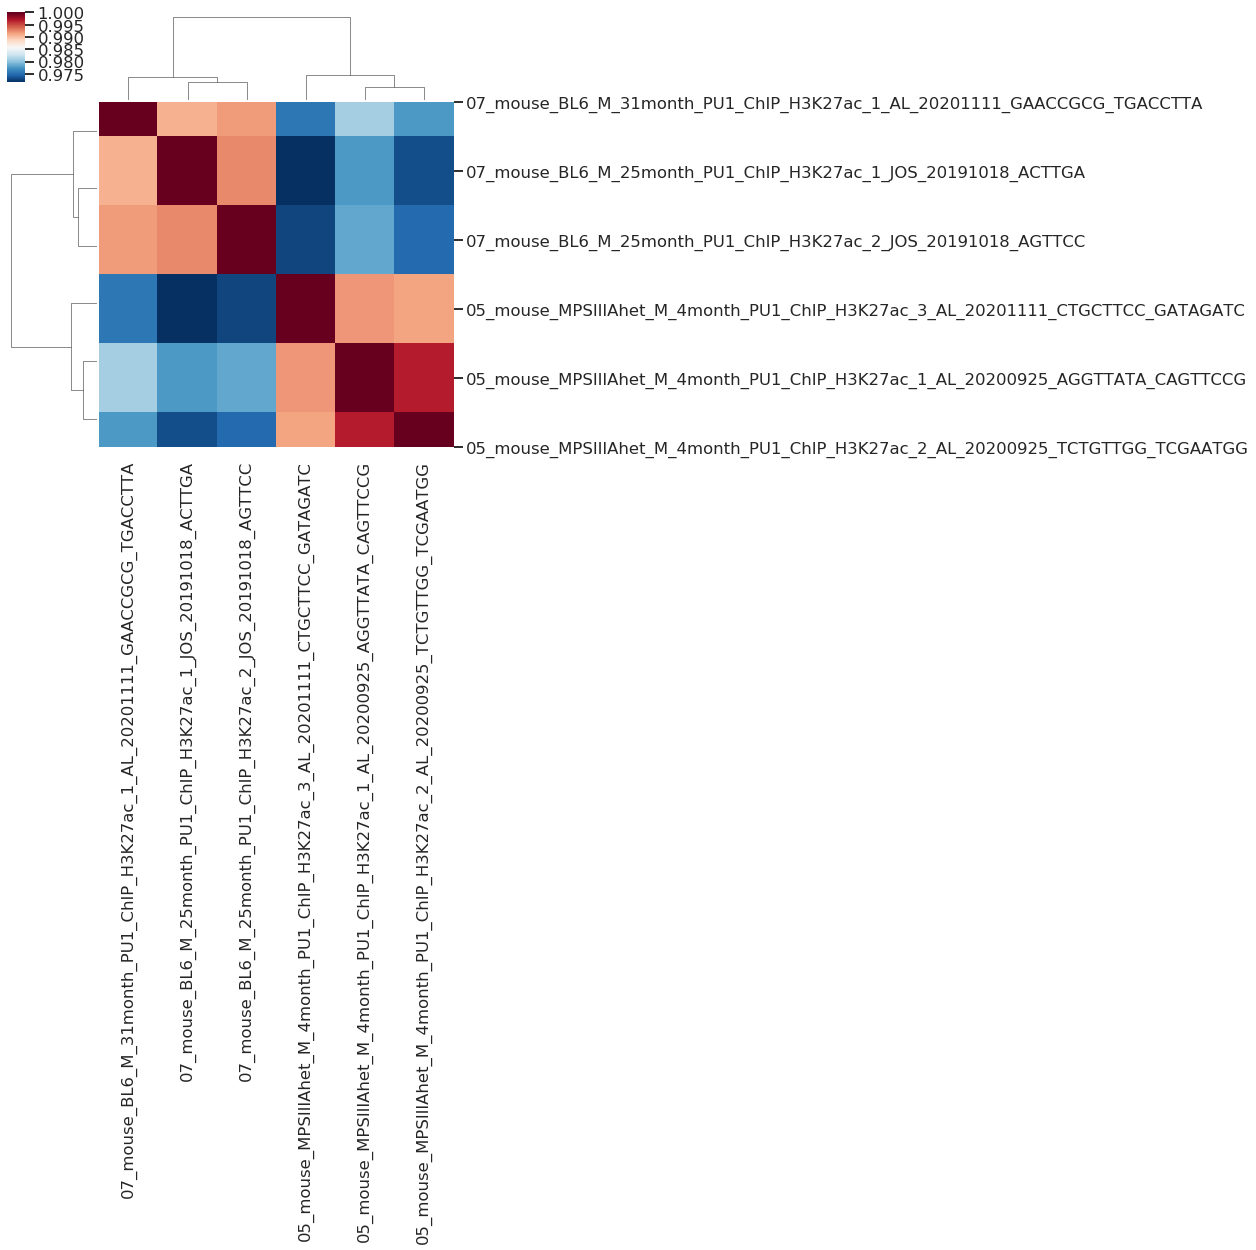

In [24]:
cm = sns.clustermap(
    mat.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap.png', bbox_inches='tight')

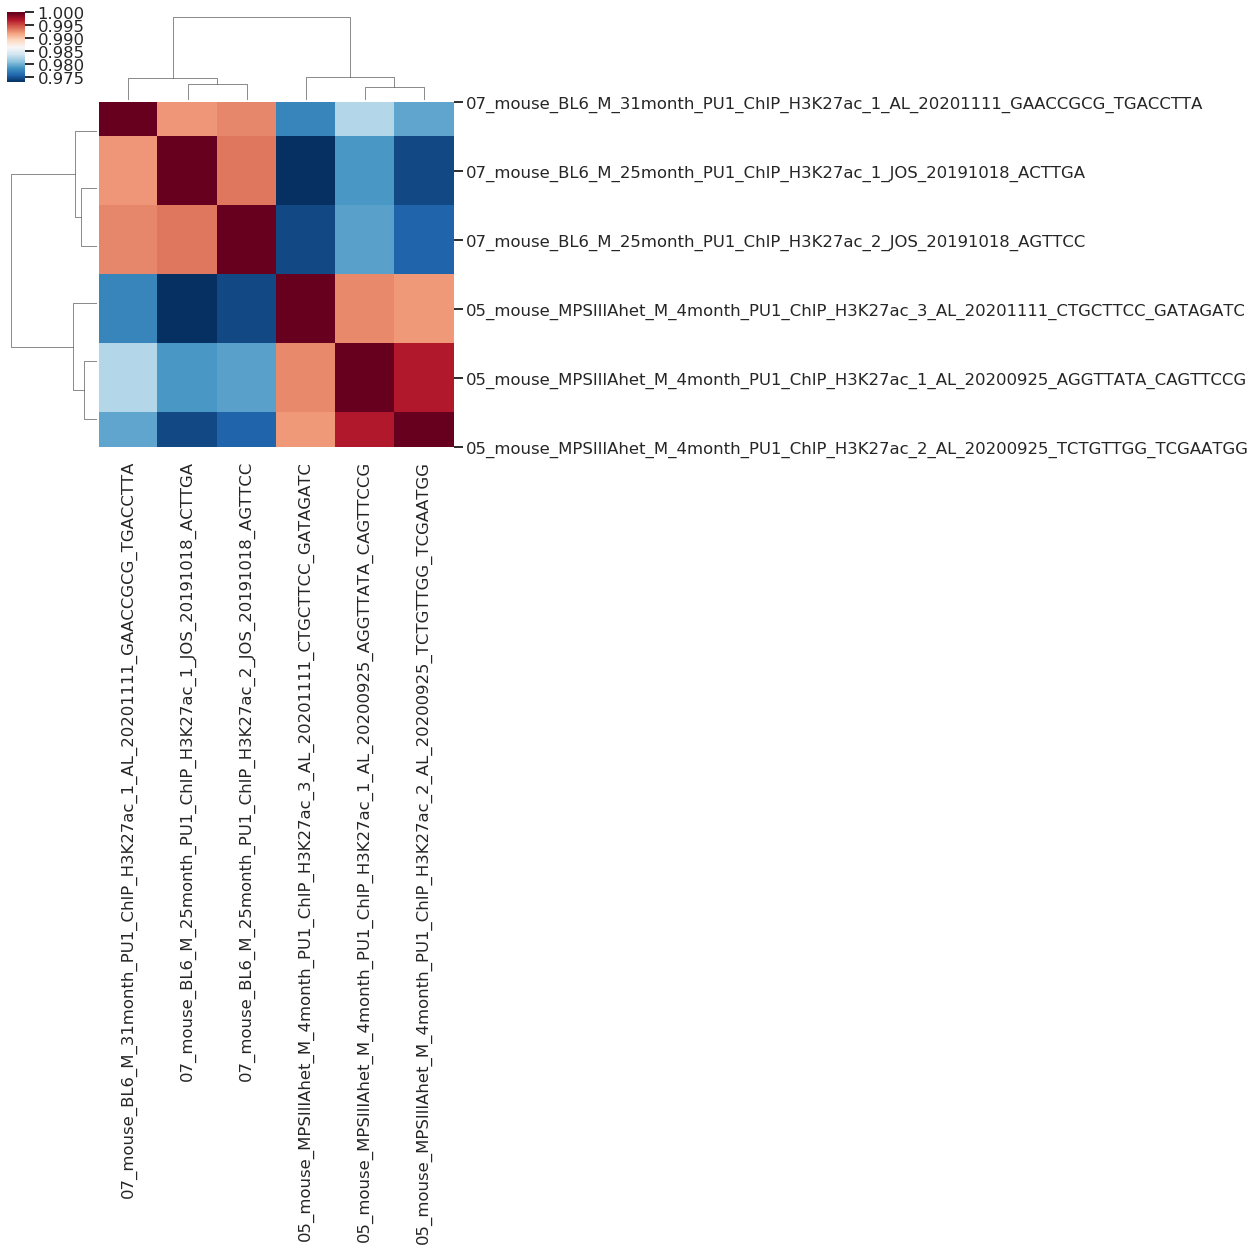

In [25]:
cm = sns.clustermap(
    mat_distal.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_distal.png', bbox_inches='tight')

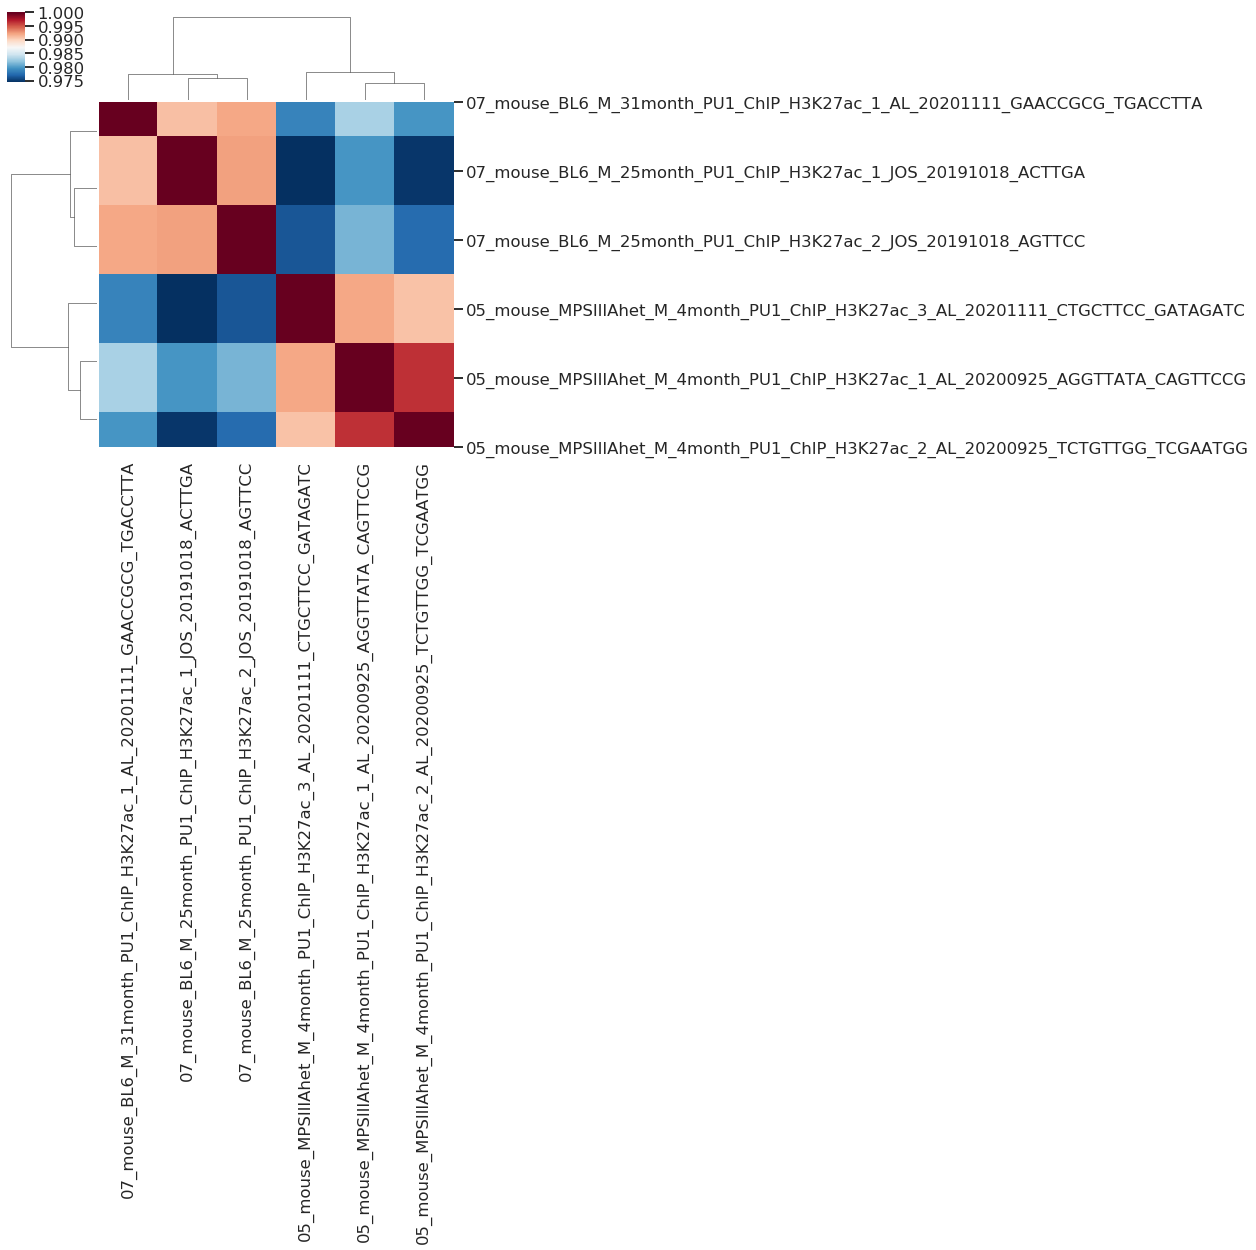

In [26]:
cm = sns.clustermap(
    mat_quant.corr(),
    cmap='RdBu_r',
    figsize=(8,8))

# adjust y axis rotation
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

plt.savefig('./figures/h3k27ac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [27]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns)
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[2]
gender = samples.str.split('_').str[3]
age = samples.str.split('_').str[4]
cell = samples.str.split('_').str[5]
rep = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[9]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(gender),
                          pd.Series(age),
                          pd.Series(cell),
                          pd.Series(rep),
                          pd.Series(sampledate)],
                         index=['mouse',
                                'group',
                                'strain',
                                'gender',
                                'age',
                                'celltype',
                                'rep',
                                'sample_date']).T

In [28]:
samplesDF

,mouse,group,strain,gender,age,celltype,rep,sample_date
0,05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_...,05,MPSIIIAhet,M,4month,PU1,1,AL
1,05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_...,05,MPSIIIAhet,M,4month,PU1,2,AL
2,05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_...,05,MPSIIIAhet,M,4month,PU1,3,AL
3,07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_...,07,BL6,M,25month,PU1,1,JOS
4,07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_...,07,BL6,M,25month,PU1,2,JOS
5,07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_2...,07,BL6,M,31month,PU1,1,AL


### Look at PCA plots for all the samples

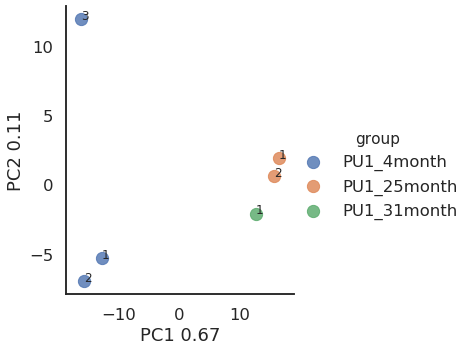

In [29]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_pca1_pca2.png', bbox_inches='tight')

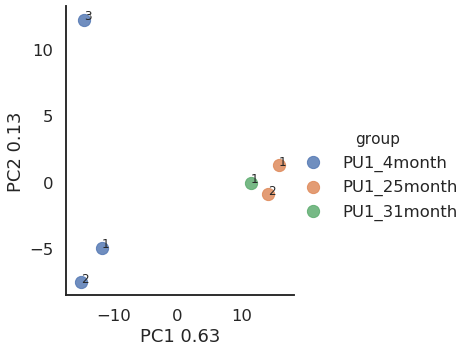

In [30]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_quantnorm_pca1_pca2.png', bbox_inches='tight')

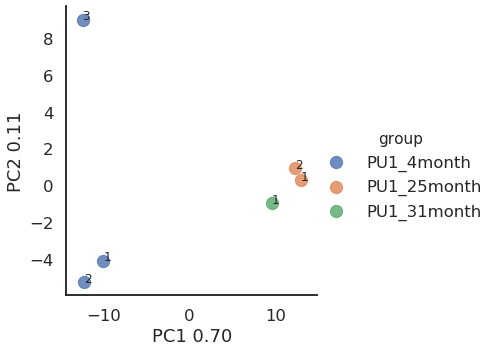

In [31]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.celltype+'_'+samplesDF.age,
                                 plot_size=5,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.rep,
            plt.gca())

plt.savefig('./figures/h3k27ac_distal_pca1_pca2.png', bbox_inches='tight')

# Plot average tag counts across peaks to assess differences

This part is sensitive to whether we include the 3 week sox9 data. it might be best to wait to do downstream analysis on this until we have deeper sequenced SOX9_10day data.

In [32]:
import itertools

## un-normalized peaks

In [33]:
for i, col in zip(range(len(mat.columns)), mat.columns):
    print(str(i)+': '+col)

0: 05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_1_AL_20200925_AGGTTATA_CAGTTCCG
1: 05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_2_AL_20200925_TCTGTTGG_TCGAATGG
2: 05_mouse_MPSIIIAhet_M_4month_PU1_ChIP_H3K27ac_3_AL_20201111_CTGCTTCC_GATAGATC
3: 07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_1_JOS_20191018_ACTTGA
4: 07_mouse_BL6_M_25month_PU1_ChIP_H3K27ac_2_JOS_20191018_AGTTCC
5: 07_mouse_BL6_M_31month_PU1_ChIP_H3K27ac_1_AL_20201111_GAACCGCG_TGACCTTA


In [36]:
groups = ['4month', '25month+']
columns = [[0,1,2],
           [3,4,5]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


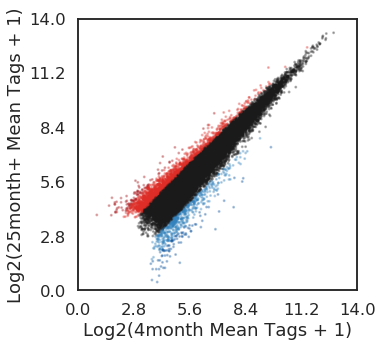

In [37]:
# set loop variables
mincount=8
thresh=[2,4]
thresh_color = {'down': ['#de2d26', '#a50f15'],
                'up': ['#3182bd', '#08519c']}
peak_count = {}

n_ticks = 5

for i, j in itertools.combinations(groups, 2):

    fig, ax = plt.subplots(figsize=(5,5))

    # filter low tag peaks
    df_tmp = avg_tags_df.loc[(avg_tags_df.loc[:, i] >= mincount) | (avg_tags_df.loc[:, j] >= mincount)]

    # set colors
    df_tmp['colors'] = 'k'
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0], 'colors'] = thresh_color['up'][0]
    peak_count['up_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0], 'colors'] = thresh_color['down'][0]
    peak_count['down_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1], 'colors'] = thresh_color['up'][1]
    peak_count['up_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1]).sum()

    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1], 'colors'] = thresh_color['down'][1]
    peak_count['down_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1]).sum()

    ax.scatter(np.log2(df_tmp.loc[:, j]+1),
               np.log2(df_tmp.loc[:, i]+1),
               s=2,
               c=df_tmp.colors,
               alpha=0.3)

    # set axis limits
    countmax = np.max([np.max(np.log2(df_tmp.loc[:, j]+1)), np.max(np.log2(df_tmp.loc[:, i]+1))])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    # fix ticks
    ax.set_xticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    ax.set_yticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    
    # label axes
    ax.set_xlabel('Log2(%s Mean Tags + 1)' % i)
    ax.set_ylabel('Log2(%s Mean Tags + 1)' % j)
    
    # save plot
    plt.savefig('./figures/'+i+'_'+j+'_pairwise_scatter.png', bbox_inches='tight')

## Quantile normalized peaks

In [38]:
groups = ['4month', '25month+']
columns = [[0,1,2],
           [3,4,5]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


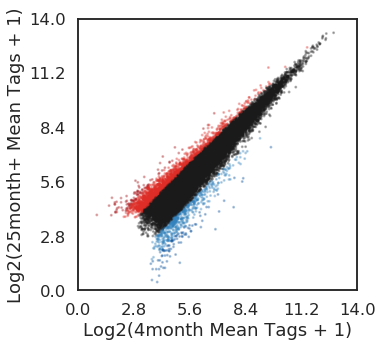

In [39]:
# set loop variables
mincount=8
thresh=[2,4]
thresh_color = {'down': ['#de2d26', '#a50f15'],
                'up': ['#3182bd', '#08519c']}
peak_count = {}

n_ticks = 5

for i, j in itertools.combinations(groups, 2):

    fig, ax = plt.subplots(figsize=(5,5))

    # filter low tag peaks
    df_tmp = avg_tags_df.loc[(avg_tags_df.loc[:, i] >= mincount) | (avg_tags_df.loc[:, j] >= mincount)]

    # set colors
    df_tmp['colors'] = 'k'
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0], 'colors'] = thresh_color['up'][0]
    peak_count['up_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0], 'colors'] = thresh_color['down'][0]
    peak_count['down_'+str(thresh[0])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[0]).sum()
    
    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1], 'colors'] = thresh_color['up'][1]
    peak_count['up_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) >= thresh[1]).sum()

    df_tmp.loc[(df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1], 'colors'] = thresh_color['down'][1]
    peak_count['down_'+str(thresh[1])] = ((df_tmp.loc[:, j] / (df_tmp.loc[:, i] + 1)) <= 1/thresh[1]).sum()

    ax.scatter(np.log2(df_tmp.loc[:, j]+1),
               np.log2(df_tmp.loc[:, i]+1),
               s=2,
               c=df_tmp.colors,
               alpha=0.3)

    # set axis limits
    countmax = np.max([np.max(np.log2(df_tmp.loc[:, j]+1)), np.max(np.log2(df_tmp.loc[:, i]+1))])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    # fix ticks
    ax.set_xticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    ax.set_yticks(np.arange(0, np.ceil(countmax)+1, np.ceil(countmax) / n_ticks))
    
    # label axes
    ax.set_xlabel('Log2(%s Mean Tags + 1)' % i)
    ax.set_ylabel('Log2(%s Mean Tags + 1)' % j)
    
    # save plot
    plt.savefig('./figures/'+i+'_'+j+'_pairwise_quantnorm_scatter.png', bbox_inches='tight')